In [38]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

# Data sources

Property data: https://www.kaggle.com/datasets/josephcheng123456/nsw-australia-property-data

Earnings: https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions/characteristics-employment-australia/aug-2023

Post codes: https://www.matthewproctor.com/australian_postcodes

Post code geodata: https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202016?OpenDocument



In [2]:
def calc_mortgage_payment(P, r, term=30):
    
    r /= 12 # make monthly
    term *= 12 # make monthly
    
    return (r * P * ((1+r)**term)) / (((1+r)**term) - 1)

def calc_borrow_capacity(payment, r, term):
    
    r /= 12 # make monthly
    term *= 12 # make monthly
    
    return payment * (((1+r)**term) - 1) / (r * ((1+r)**term))

In [3]:
calc_borrow_capacity(4300, 0.062, 30)

702076.3758630457

In [4]:
path = "nsw_property_data.csv"

df = pd.read_csv(
    path,
    dtype = {
        'post_code': str,
        'property_id': str,
        'purchase_price': float,
        
    },
    parse_dates = [
        'settlement_date',
        'download_date',
        'contract_date'
    ],
)

In [5]:
# filter just residential property
df_res = df[df['primary_purpose'] == 'RESIDENCE']
df_res.head()

,property_id,download_date,council_name,purchase_price,address,post_code,property_type,strata_lot_number,property_name,area,area_type,contract_date,settlement_date,nature_of_property,primary_purpose,legal_description
0,1216810,2023-02-27,CABONNE,3200000.0,"5796 MITCHELL HWY, LARRAS LEE",2866,house,NaN,THREE RIVERS,147.20,H,2022-10-20,2022-12-05,R,RESIDENCE,PT 2/630113
2,3380305,2023-02-27,CABONNE,4125000.0,"244 CROCKETTS LANE, LARRAS LEE",2866,house,NaN,BONNIE DOON,213.38,H,2022-07-28,2023-02-20,R,RESIDENCE,84/756908
3,2082468,2023-02-27,WOOLLAHRA,1450000.0,"2/110 CASCADE ST, PADDINGTON",2021,unit,2.0,NaN,123.00,M,2022-12-09,2023-02-17,R,RESIDENCE,2/SP19410
4,2080204,2023-02-27,WOOLLAHRA,2400000.0,"2/6 BERESFORD RD, ROSE BAY",2029,unit,2.0,NaN,198.80,M,2022-10-20,2023-02-23,R,RESIDENCE,2/SP5601
5,2099507,2023-02-27,WOOLLAHRA,7125000.0,"15 ROBINSON LANE, WOOLLAHRA",2025,house,NaN,NaN,600.70,M,2022-09-16,2023-02-16,R,RESIDENCE,B/392435


In [6]:
# get locality data
df_pc = pd.read_csv('australian_postcodes.csv', dtype = {'postcode': str})

sydney_postcodes = list(set(df_pc[(df_pc.state == 'NSW') & (df_pc.region == 'R1')].postcode))

In [7]:
# calculate house price for median income based on repayments only

def calculate_borrow_cap_from_weekly_income(income, rate, term, repayment_pc, deposit_pc):
    monthly_repayment = income * repayment_pc * 52 / 12
    
    return calc_borrow_capacity(monthly_repayment, rate, term) / (1-deposit_pc)

median_weekly_income = 1686.60

single_median = calculate_borrow_cap_from_weekly_income(median_weekly_income, 0.062, 30, 0.3, 0.2)
double_median = calculate_borrow_cap_from_weekly_income(median_weekly_income*2, 0.062, 30, 0.3, 0.2)

single_median_50 = calculate_borrow_cap_from_weekly_income(median_weekly_income, 0.062, 30, 0.5, 0.2) 
double_median_50 = calculate_borrow_cap_from_weekly_income(median_weekly_income*2, 0.062, 30, 0.5, 0.2)

In [13]:
double_median_50

1491626.5699513531

# Can the median income afford a median propery?

According to the ABS, the median income in greater Sydney was $1,686.6 per week in Aug 2023. If we take affordable to mean that you are spending 30% of your income on housing, then we can see if the median person or median couple can afford the median house. In these calculations, we are assuming that the imaginary buyer has a 20% deposit and are paying a rate of 6.2% (a typical rate in Jan 2024).

From the graph below, we see that the median person in Sydney cannot afford the median property, but the median couple can almost afford the median property. 

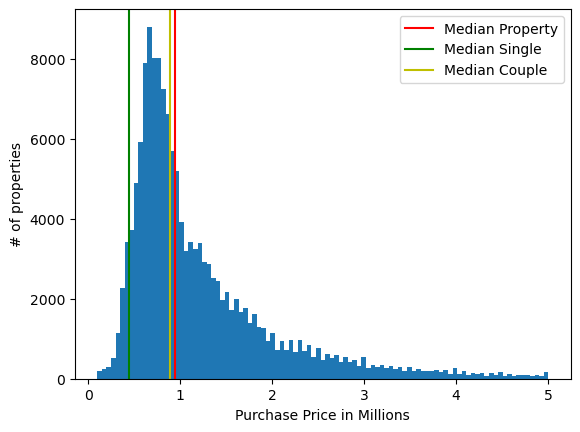

In [18]:
# explore purchase price

# filter sales to Sydney:
df_res_syd = df_res[df_res['post_code'].isin(sydney_postcodes)]

# filter to sales after 2020:
df_res_syd_2020 = df_res_syd[df_res_syd['settlement_date'] > pd.to_datetime('2020-1-1')]

ax = df_res_syd_2020.hist('purchase_price', bins=np.linspace(100_000,5_000_000, 100), grid=False)

# Set the formatter for the x-axis
ax[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x * 1e-6)}'))

ax[0][0].set_xlabel('Purchase Price in Millions')
ax[0][0].set_ylabel('# of properties')

# calculate medians
median_property_price = df_res_syd_2020['purchase_price'].median()
median_house_price = df_res_syd_2020[df_res_syd_2020.property_type == 'house']['purchase_price'].median()
median_unit_price = df_res_syd_2020[df_res_syd_2020.property_type == 'unit']['purchase_price'].median()

# add a median line
ax[0][0].axvline(median_property_price, color='r', label='Median Property')
ax[0][0].axvline(single_median, color='g', label='Median Single')
ax[0][0].axvline(double_median, color='y', label='Median Couple')
ax[0][0].legend()

ax[0][0].set_title('')
plt.show()

### Units vs Houses
What about if we split the dataset up into units and houses? Well, the median individual can still not afford anything except the cheapest properties but the median couple can afford slightly higher than the median unit but definitely cannot afford the median house. 

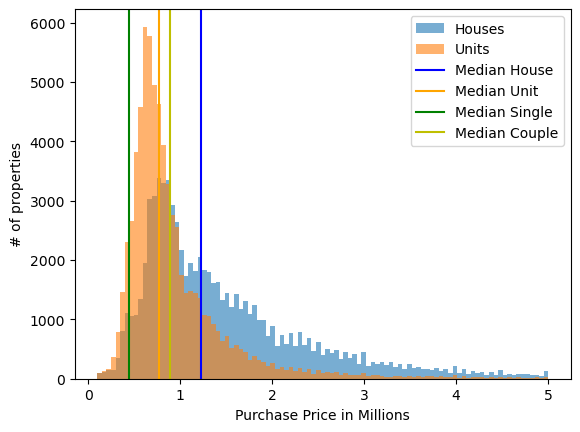

In [19]:
ax = df_res_syd_2020[df_res_syd_2020.property_type == 'house'].hist('purchase_price', bins=np.linspace(100_000,5_000_000, 100), grid=False, label='Houses', alpha=0.6)
df_res_syd_2020[df_res_syd_2020.property_type == 'unit'].hist('purchase_price', bins=np.linspace(100_000,5_000_000, 100), grid=False, ax=ax[0][0], label='Units', alpha=0.6)
# Set the formatter for the x-axis
ax[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x * 1e-6)}'))

ax[0][0].set_xlabel('Purchase Price in Millions')
ax[0][0].set_ylabel('# of properties')


# add a median line
ax[0][0].axvline(median_house_price, color='blue', label='Median House')
ax[0][0].axvline(median_unit_price, color='orange', label='Median Unit')
ax[0][0].axvline(single_median, color='g', label='Median Single')
ax[0][0].axvline(double_median, color='y', label='Median Couple')
ax[0][0].legend()

ax[0][0].set_title('')
plt.show()

# How has property price changed vs income over time

In [20]:
historic_median_property_price = []
year = []
for i in range(1980, 2022):
    year.append(i)
    yr_median = df_res_syd[
        (df_res_syd['settlement_date'] > pd.to_datetime(f'{i}-1-1')) 
        & (df_res_syd['settlement_date'] < pd.to_datetime(f'{i+1}-1-1'))
    ].median()['purchase_price']
    historic_median_property_price.append(yr_median)

/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None

/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None

/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  yr_median = df_res_syd[
/var/folders/jh/5p47w4fx6dn9fb1qx859422c0000gn/T/ipykernel_23004/3220123260.py:5: FutureWarning: DataFra

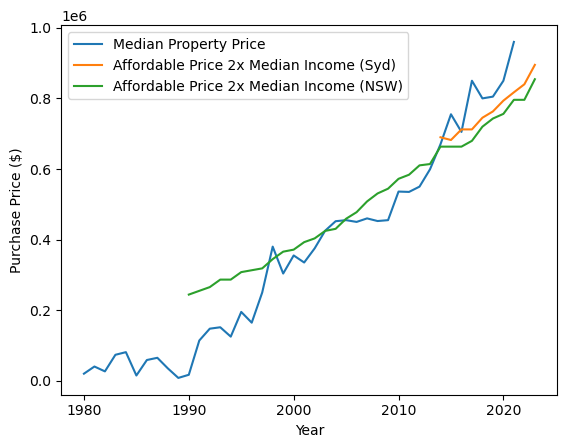

In [21]:
median_weekly_fulltime_nsw_year = [1990, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
median_weekly_fulltime_nsw = [460.0, 500.0, 540.0, 540.0, 580.0, 600.0, 649.4, 689.2, 700.0, 740.0, 760.0, 800.0, 811.1, 865.0, 900.0, 957.5, 1000.0, 1025.5, 1078.2, 1100.0, 1150.0, 1157.0, 1250.0, 1250.0, 1250.0, 1281.0, 1356.6, 1400.0, 1425.0, 1500.0, 1500.0, 1610.0] 
median_weekly_fulltime_syd_year = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
median_weekly_fulltime_syd = [1300.0, 1285.4, 1342.0, 1342.0, 1404.4, 1438.0, 1495.6, 1540.0, 1583.0, 1686.6]

median_affordable_fulltime_syd = [calculate_borrow_cap_from_weekly_income(x*2, 0.062, 30, 0.3, 0.2) for x in median_weekly_fulltime_syd]
median_affordable_fulltime_nsw = [calculate_borrow_cap_from_weekly_income(x*2, 0.062, 30, 0.3, 0.2) for x in median_weekly_fulltime_nsw]

fig, ax = plt.subplots(1,1)
ax.plot(year, historic_median_property_price, label='Median Property Price')
ax.plot(median_weekly_fulltime_syd_year, median_affordable_fulltime_syd, label='Affordable Price 2x Median Income (Syd)')
ax.plot(median_weekly_fulltime_nsw_year, median_affordable_fulltime_nsw, label='Affordable Price 2x Median Income (NSW)')
ax.legend()

#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x * 1e-5)}'))
ax.set_xlabel('Year')
ax.set_ylabel('Purchase Price ($)')
plt.show()

# Where can a median income purchase a property?

Just looking at how many properties are affordable doesn't tell the whole story, especially given the fact Sydney is such a sprawling city. To understand *where* a median income can afford to purchase, we can look at the how many properties were sold since 2023 in each postcode. 

In [22]:
au_pc = gpd.read_file('1270055003_poa_2016_aust_shape/POA_2016_AUST.shp')
syd_pc = au_pc[au_pc['POA_CODE16'].isin(sydney_postcodes)]

In [23]:
# process the property data to find how many properties and their prices are in each post code and add the 
# geometry data
def group_and_aggregate(df, price_col, median_price):
    """ Group by 'post_code' and aggregate metrics for a given DataFrame. """
    
    df = df.copy()

    # Create a new column in the DataFrame to indicate if the price is below the median
    df['below_median'] = df[price_col] < median_price

    # Group by 'post_code' and calculate the required metrics
    grouped_df = df.groupby('post_code').agg(
        total_count=('post_code', 'size'),
        count_below_median=('below_median', 'sum'),  # Summing boolean values gives the count of True values
        average_purchase_price=(price_col, 'mean'),
        median_purchase_price=(price_col, 'median'),
    )
    
    grouped_df['proportion_affordable'] = grouped_df['count_below_median'] / grouped_df['total_count']
    
    return syd_pc.merge(grouped_df, left_on='POA_CODE16', right_on='post_code')


# Applying the function to each subset
grouped_median_property = group_and_aggregate(df_res_syd_2020, 'purchase_price', median_property_price)
grouped_median_house = group_and_aggregate(df_res_syd_2020[df_res_syd_2020.property_type == 'house'], 'purchase_price', median_house_price)
grouped_median_unit = group_and_aggregate(df_res_syd_2020[df_res_syd_2020.property_type == 'unit'], 'purchase_price', median_unit_price)
grouped_median_single = group_and_aggregate(df_res_syd_2020, 'purchase_price', single_median)
grouped_median_couple = group_and_aggregate(df_res_syd_2020, 'purchase_price', double_median)
grouped_median_house_couple = group_and_aggregate(df_res_syd_2020[df_res_syd_2020.property_type == 'house'], 'purchase_price', double_median)
grouped_median_unit_couple = group_and_aggregate(df_res_syd_2020[df_res_syd_2020.property_type == 'unit'], 'purchase_price', double_median)


In [24]:
median_property_price

945000.0

In [25]:
def plot_geo_data(df, column, title):

    fig, ax = plt.subplots(figsize=(8,8), dpi=150)
    df.plot(
        column=column, 
        cmap='coolwarm_r', 
        legend = True, 
        ax=ax, 
        linewidth=0.5, 
        edgecolor='black', 
        alpha=0.6
    )
    ax.axis('off')
    ax.set_title(title)
    plt.show()

### Proportion of property since 2020 affordable for two median incomes

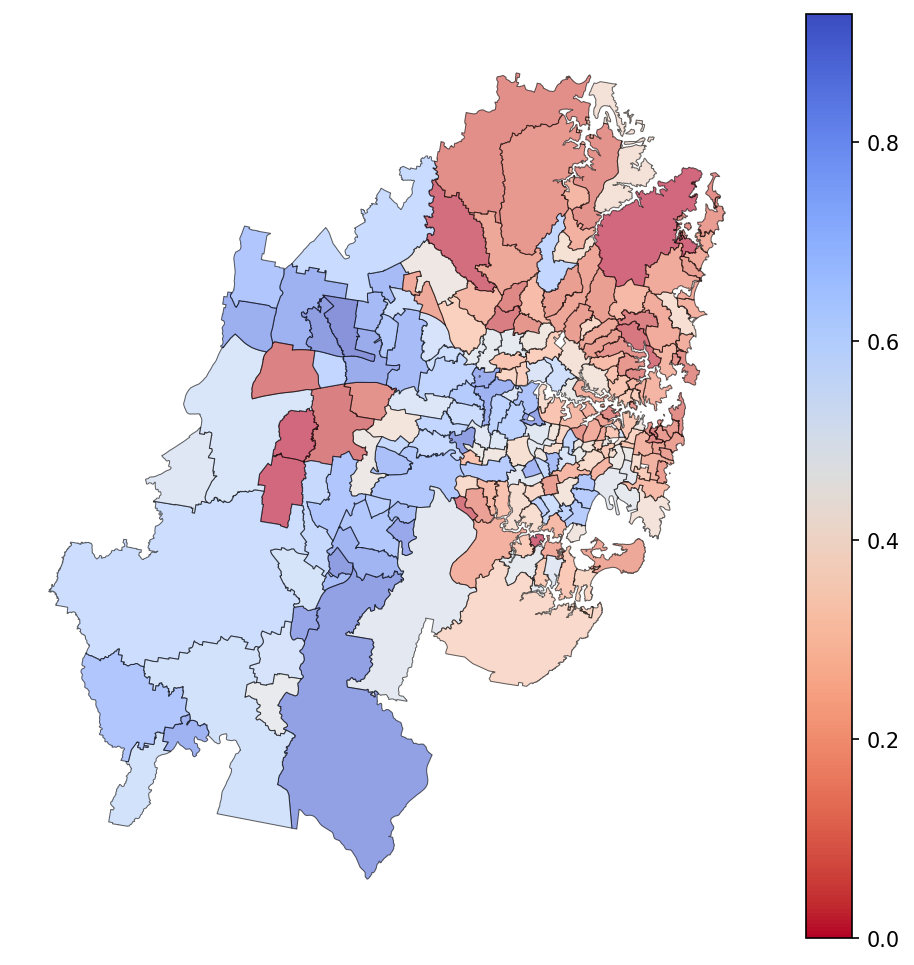

In [26]:
plot_geo_data(grouped_median_couple, 'proportion_affordable', '')

### Proportion of property since 2020 affordable for one median incomes

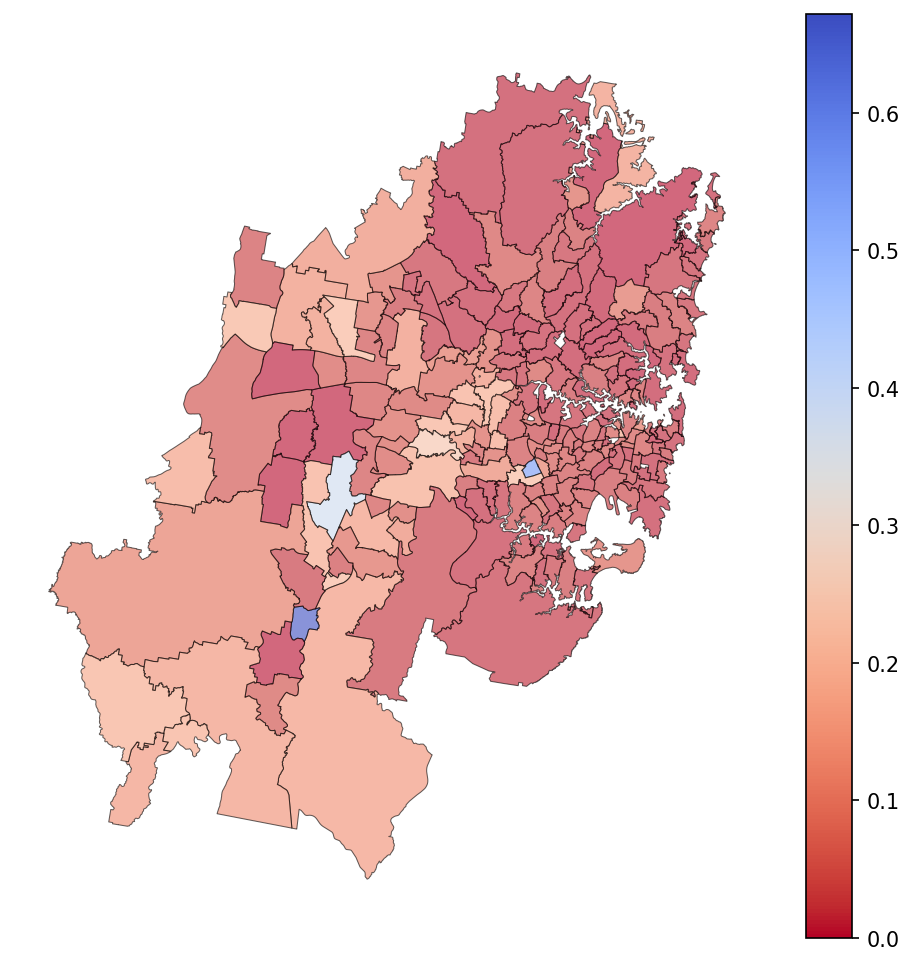

In [27]:
plot_geo_data(grouped_median_single, 'proportion_affordable', '')

In [28]:
grouped_median_single[grouped_median_single['proportion_affordable'] > 0.5]

,POA_CODE16,POA_NAME16,AREASQKM16,geometry,total_count,count_below_median,average_purchase_price,median_purchase_price,proportion_affordable
157,2195,2195,3.5488,"POLYGON ((151.06747 -33.91381, 151.06799 -33.9...",569,315,665982.265378,421000.0,0.553603
200,2563,2563,11.5603,"POLYGON ((150.73992 -34.09393, 150.74001 -34.0...",67,45,764856.522388,402500.0,0.671642


There are exactly two postcodes affordable to a single median income: Lakemba (2195) and Menangle Park (2563).

### Proportion of units sold since 2020 below median

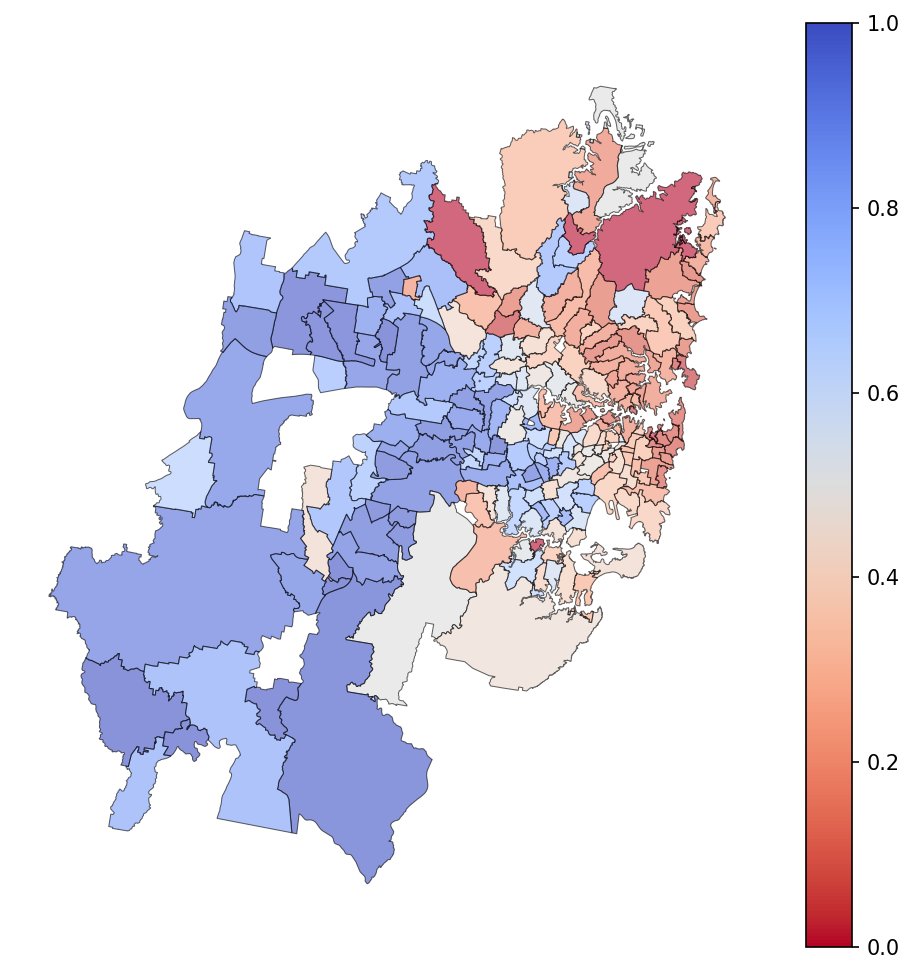

In [29]:
plot_geo_data(grouped_median_unit, 'proportion_affordable', '')

### Proportion of houses sold since 2020 below median

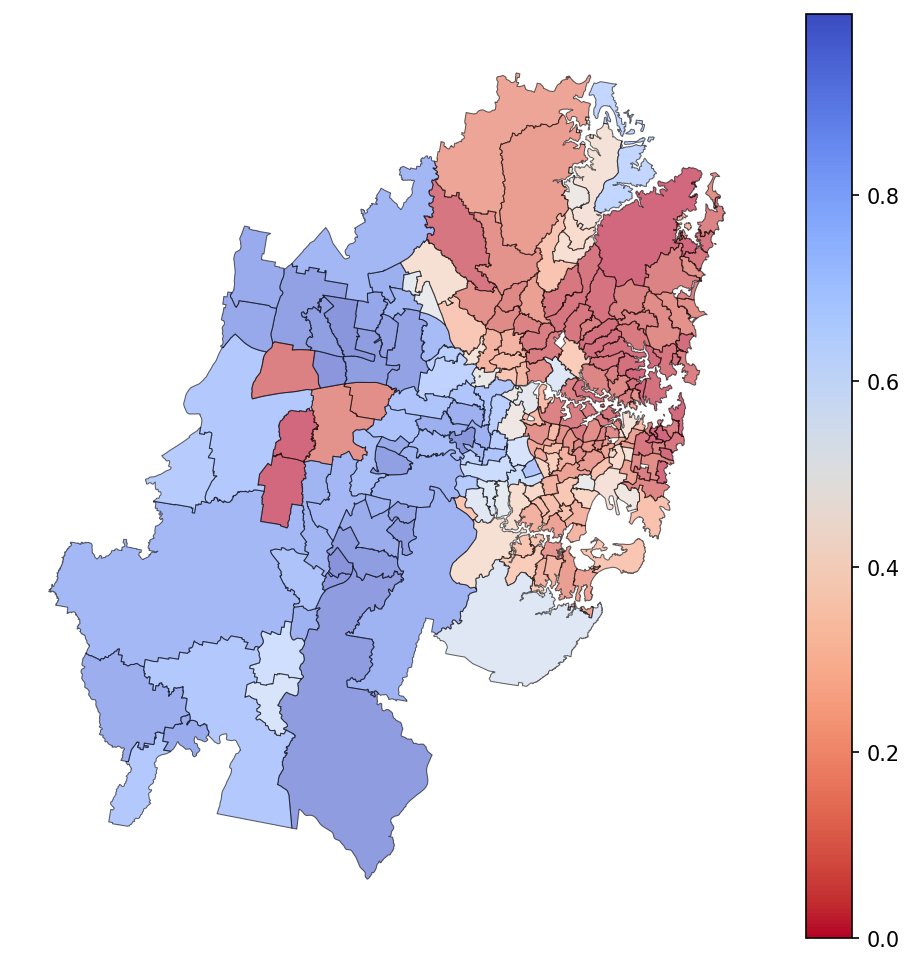

In [30]:
plot_geo_data(grouped_median_house, 'proportion_affordable', '')

### Proportion of units since 2020 affordable for two median incomes

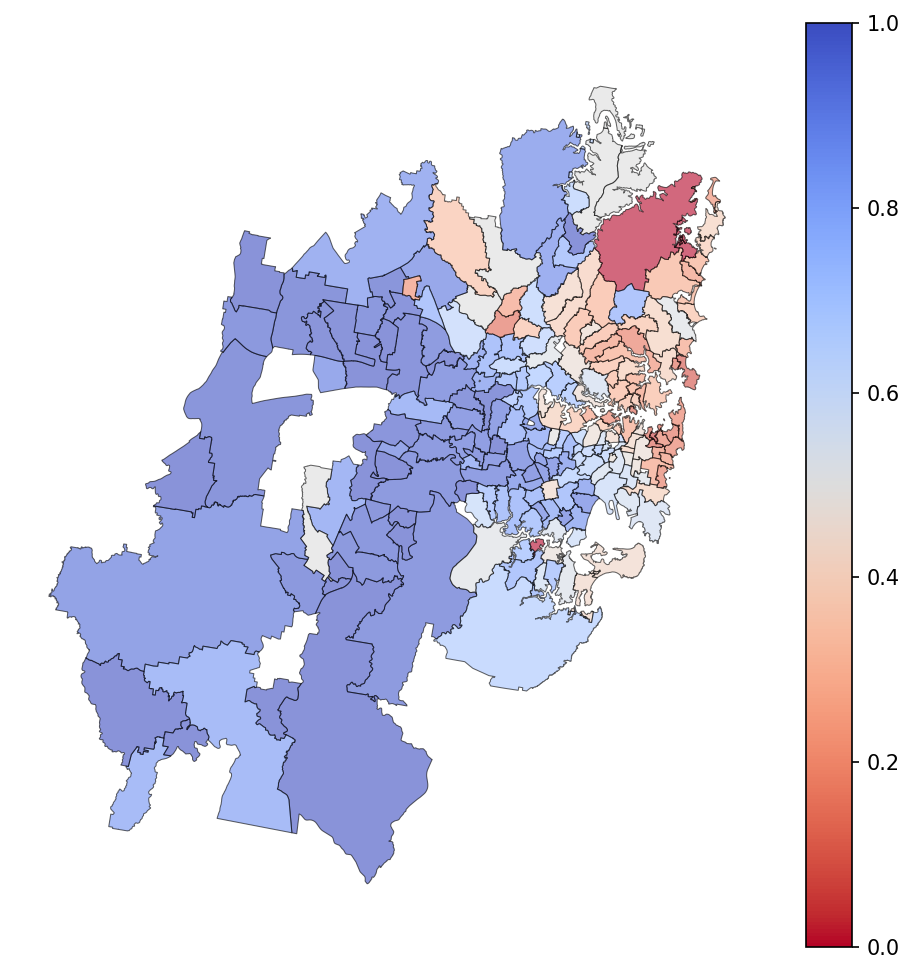

In [31]:
plot_geo_data(grouped_median_unit_couple, 'proportion_affordable', '')

### Proportion of houses sold since 2020 affordable for two median incomes

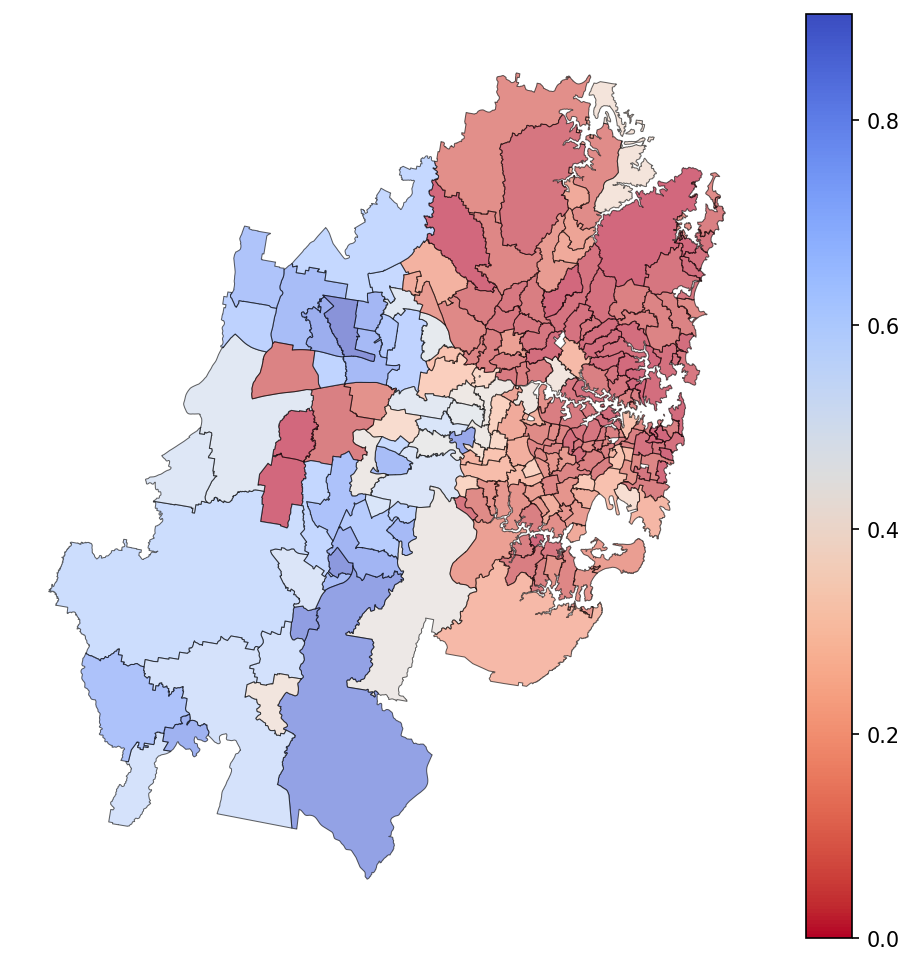

In [32]:
plot_geo_data(grouped_median_house_couple, 'proportion_affordable', '')

# Property as an investment

Sydney (and Australia as a whole) is a bit strange in that your property is generally more than where you live, it is also your biggest and usually most significant investment. Now, this is of course a bit of a contentious topic given its basically impossible to truly cash out this investment because selling a home usually entails buying another home, but for the sake of this analysis, lets assume we will treat property as an investment as well as a dwelling. 

In this case, affordable can mean that you spend 30% of your income on housing plus 20% of your income on investment. Except in this case all of that is going into your mortgage. 

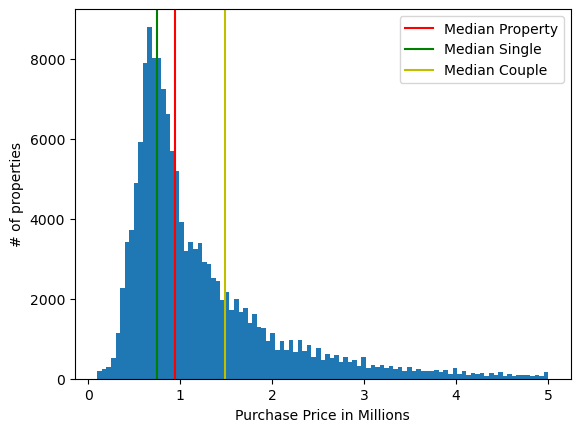

In [33]:
ax = df_res_syd_2020.hist('purchase_price', bins=np.linspace(100_000,5_000_000, 100), grid=False)

# Set the formatter for the x-axis
ax[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x * 1e-6)}'))

ax[0][0].set_xlabel('Purchase Price in Millions')
ax[0][0].set_ylabel('# of properties')

# calculate medians
median_property_price = df_res_syd_2020['purchase_price'].median()
median_house_price = df_res_syd_2020[df_res_syd_2020.property_type == 'house']['purchase_price'].median()
median_unit_price = df_res_syd_2020[df_res_syd_2020.property_type == 'unit']['purchase_price'].median()

# add a median line
ax[0][0].axvline(median_property_price, color='r', label='Median Property')
ax[0][0].axvline(single_median_50, color='g', label='Median Single')
ax[0][0].axvline(double_median_50, color='y', label='Median Couple')
ax[0][0].legend()

ax[0][0].set_title('')
plt.show()

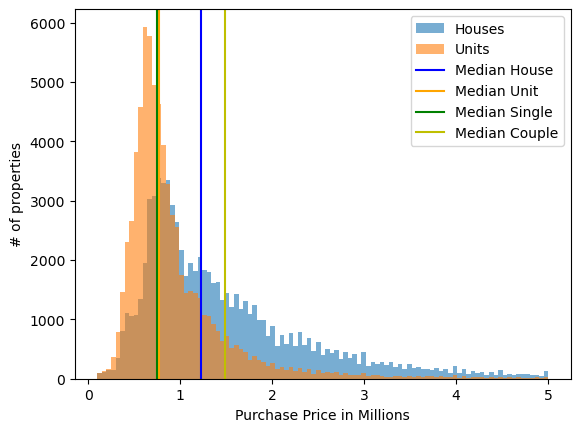

In [34]:
ax = df_res_syd_2020[df_res_syd_2020.property_type == 'house'].hist('purchase_price', bins=np.linspace(100_000,5_000_000, 100), grid=False, label='Houses', alpha=0.6)
df_res_syd_2020[df_res_syd_2020.property_type == 'unit'].hist('purchase_price', bins=np.linspace(100_000,5_000_000, 100), grid=False, ax=ax[0][0], label='Units', alpha=0.6)
# Set the formatter for the x-axis
ax[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x * 1e-6)}'))

ax[0][0].set_xlabel('Purchase Price in Millions')
ax[0][0].set_ylabel('# of properties')


# add a median line
ax[0][0].axvline(median_house_price, color='blue', label='Median House')
ax[0][0].axvline(median_unit_price, color='orange', label='Median Unit')
ax[0][0].axvline(single_median_50, color='g', label='Median Single')
ax[0][0].axvline(double_median_50, color='y', label='Median Couple')
ax[0][0].legend()

ax[0][0].set_title('')
plt.show()

With this new paradigm where we treat property as an investment as well as well as a dwelling, it is starting to make more sense. A single median income can afford the median unit and two median incomes can afford more than the median house. What this tells us is that housing in Sydney is not treated just as housing, it is treated as your main investment, which means to keep up you have to also treat it as an investiment and sink half of your pay into your mortgage if you want to keep up. How our hypothetical median couple saves 20% for the deposit, I'm not sure. 

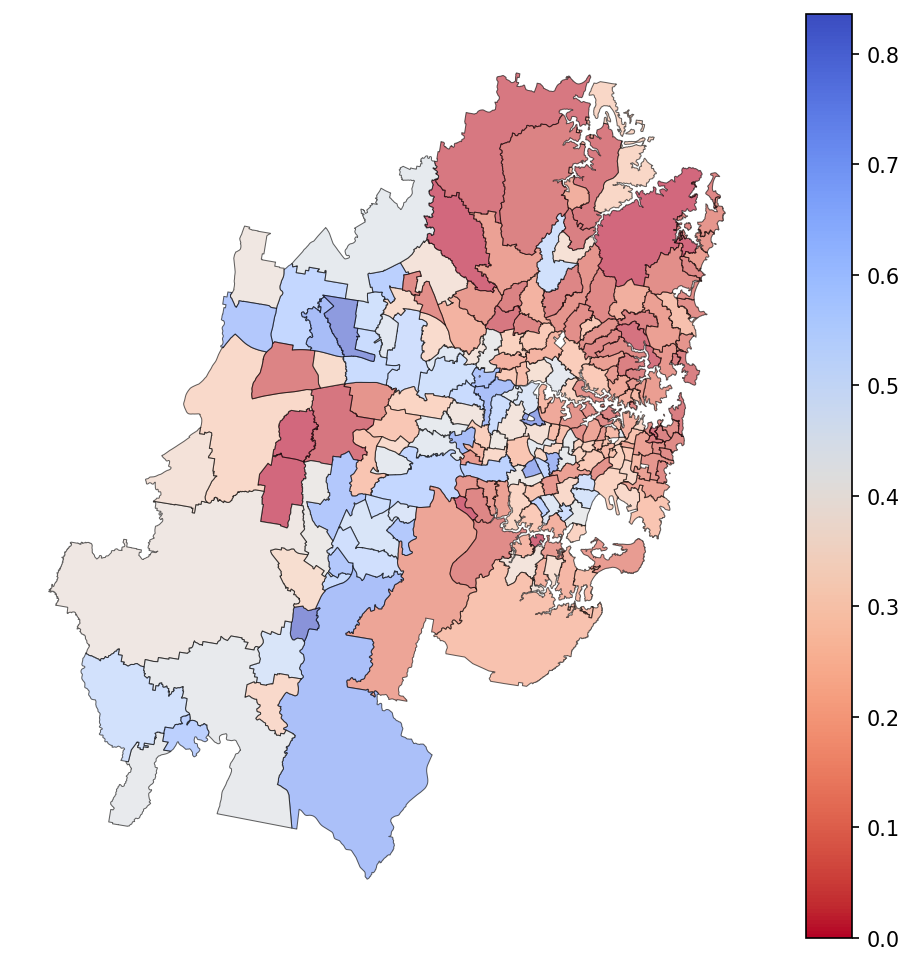

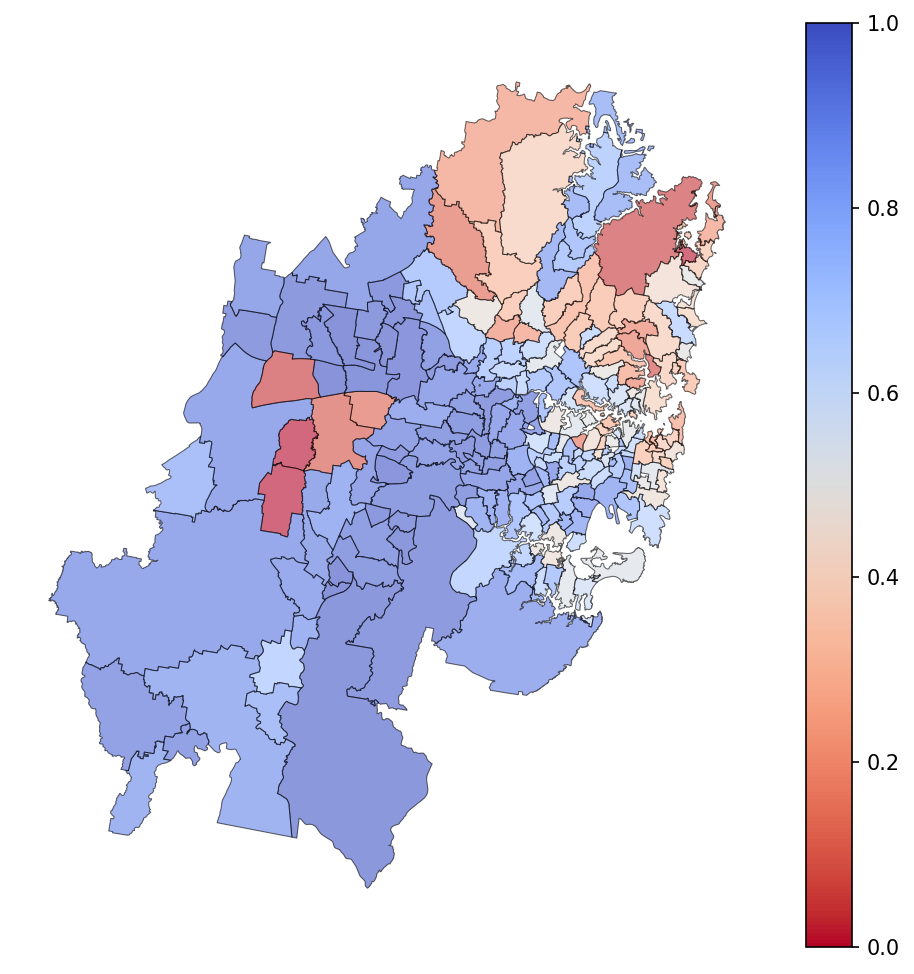

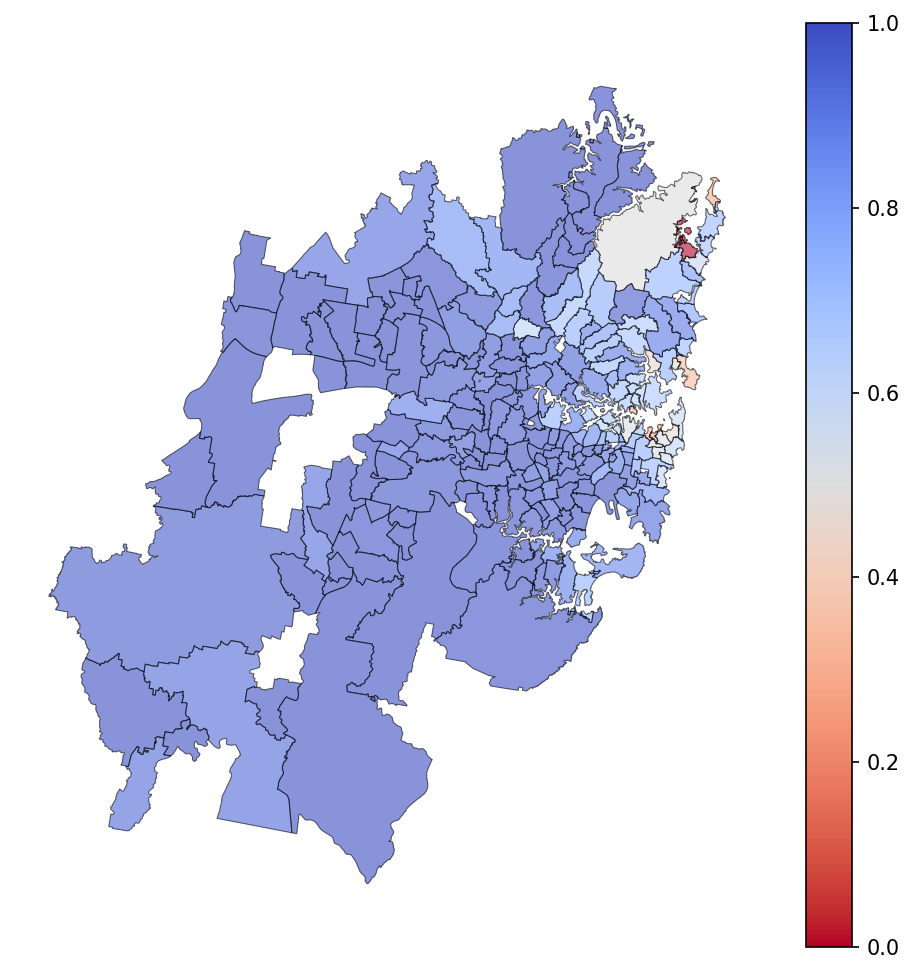

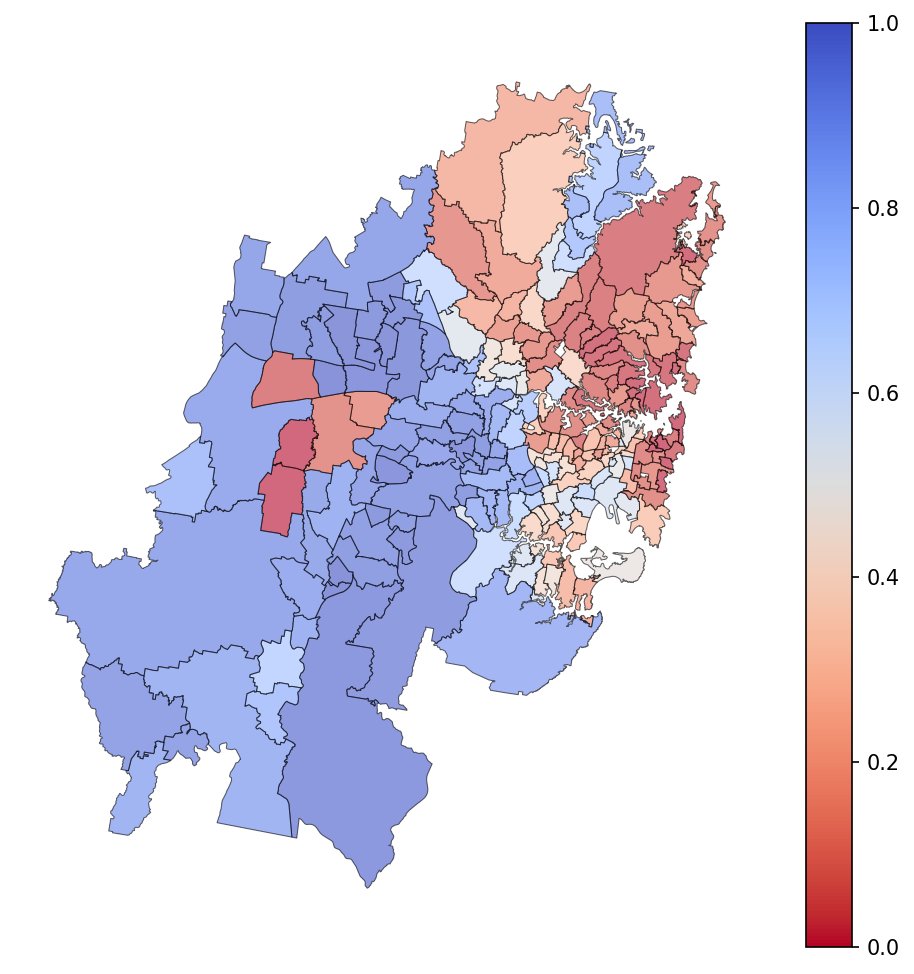

In [35]:
grouped_median_single_50 = group_and_aggregate(df_res_syd_2020, 'purchase_price', single_median_50)
grouped_median_couple_50 = group_and_aggregate(df_res_syd_2020, 'purchase_price', double_median_50)
grouped_median_house_couple_50 = group_and_aggregate(df_res_syd_2020[df_res_syd_2020.property_type == 'house'], 'purchase_price', double_median_50)
grouped_median_unit_couple_50 = group_and_aggregate(df_res_syd_2020[df_res_syd_2020.property_type == 'unit'], 'purchase_price', double_median_50)

plot_geo_data(grouped_median_single_50, 'proportion_affordable', '')
plot_geo_data(grouped_median_couple_50, 'proportion_affordable', '')
plot_geo_data(grouped_median_unit_couple_50, 'proportion_affordable', '')
plot_geo_data(grouped_median_house_couple_50, 'proportion_affordable', '')